# Data Science Salaries

## 1. Data Analysis and Preprocessing

In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Set style for better visualizations
sns.set_style("whitegrid")
sns.set_palette("husl")

path = "data\\ds_salaries.csv"

# Load the dataset
df = pd.read_csv(path)

def prepare_data(df):
    # Create copy to avoid modifying original data
    data = df.copy()
    
    # Convert salary_in_usd to thousands for better readability
    data['salary_in_usd'] = data['salary_in_usd'] / 1000
    
    # Label encode categorical variables
    le = LabelEncoder()
    categorical_cols = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']
    
    for col in categorical_cols:
        data[col + '_encoded'] = le.fit_transform(data[col])
    
    return data

In [8]:
# Prepare data
processed_data = prepare_data(df)

## 2. Visualizations

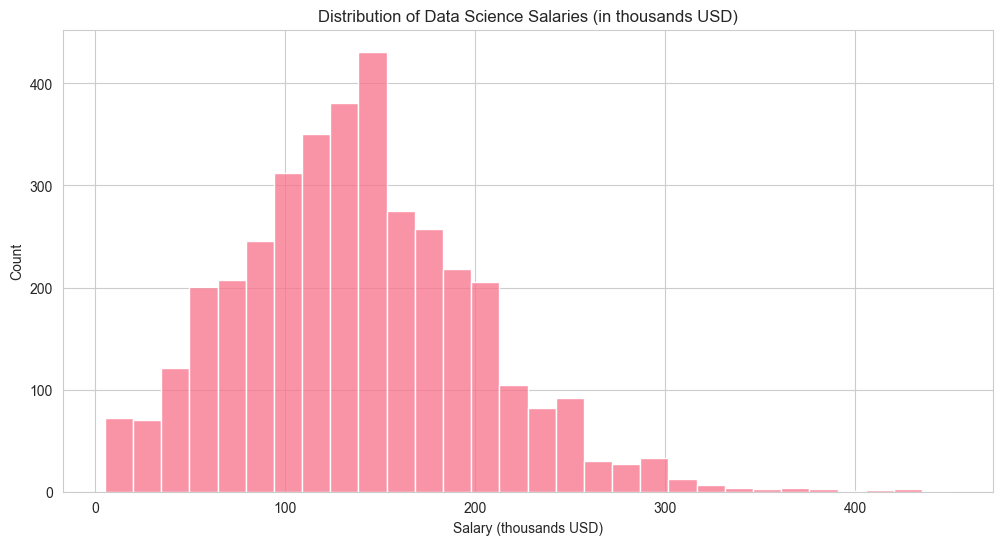

In [22]:
# 2.1 Salary Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=processed_data, x='salary_in_usd', bins=30)
plt.title('Distribution of Data Science Salaries (in thousands USD)')
plt.xlabel('Salary (thousands USD)')
plt.ylabel('Count')
plt.show()

This histogram reveals the overall salary distribution, helping us understand the central tendency, spread, and potential outliers in data science compensation. It's crucial for identifying salary ranges and potential skewness in the dataset.

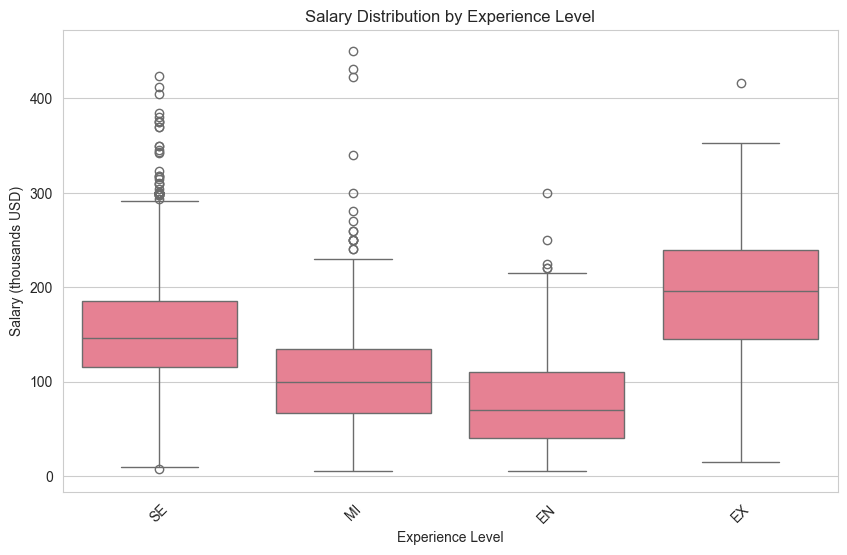

In [23]:
# 2.2 Salary by Experience Level
plt.figure(figsize=(10, 6))
sns.boxplot(data=processed_data, x='experience_level', y='salary_in_usd')
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary (thousands USD)')
plt.xticks(rotation=45)
plt.show()

The box plot compares salary distributions across different experience levels, revealing how compensation progresses with career advancement. This visualization helps identify salary progression, median values, and outliers for each experience tier.

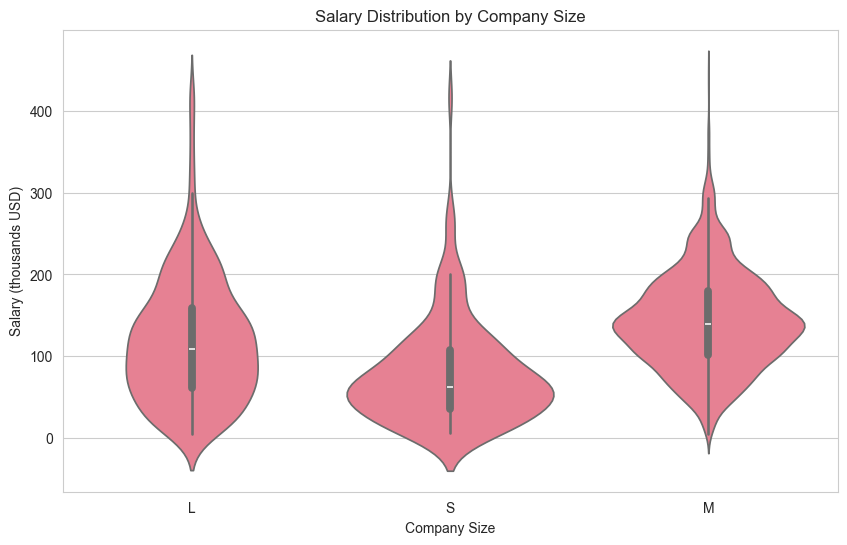

In [24]:
# 2.3 Salary by Company Size
plt.figure(figsize=(10, 6))
sns.violinplot(data=processed_data, x='company_size', y='salary_in_usd')
plt.title('Salary Distribution by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Salary (thousands USD)')
plt.show()

The violin plot shows the nuanced salary distribution across different company sizes. Unlike a simple box plot, it reveals the full probability density, highlighting how company size impacts salary structure and variability.

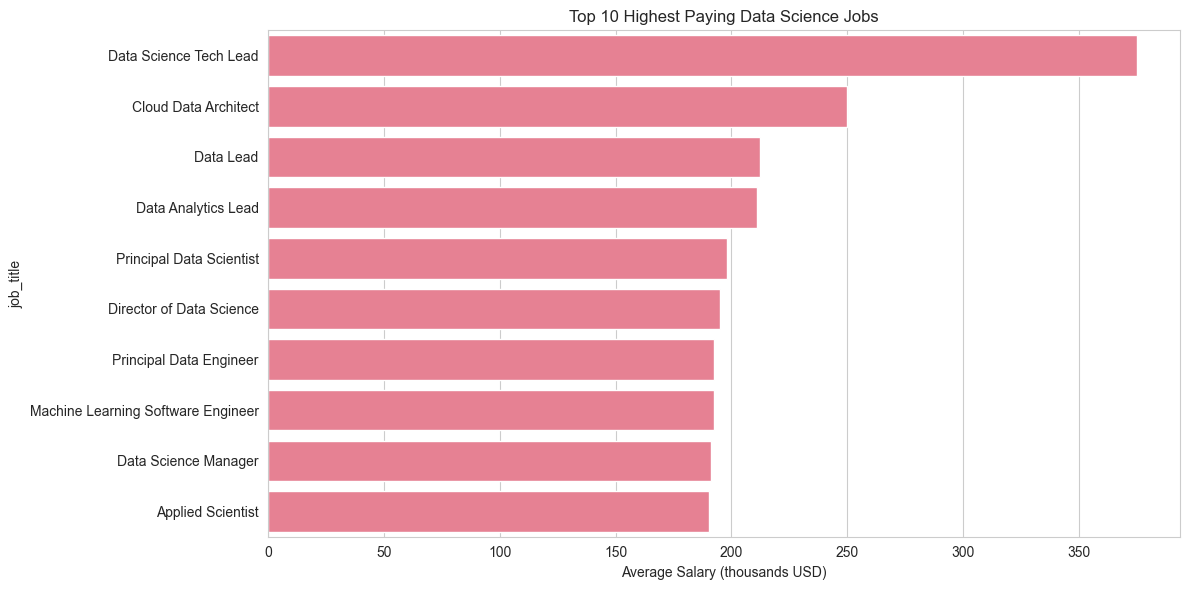

In [25]:
# 2.4 Top 10 Paying Job Titles
plt.figure(figsize=(12, 6))
job_salary = processed_data.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=job_salary.values, y=job_salary.index)
plt.title('Top 10 Highest Paying Data Science Jobs')
plt.xlabel('Average Salary (thousands USD)')
plt.tight_layout()
plt.show()

This bar chart identifies the highest-paying job titles in data science, providing insight into career paths and potential salary expectations. It helps understand which specific roles command the highest compensation in the field.

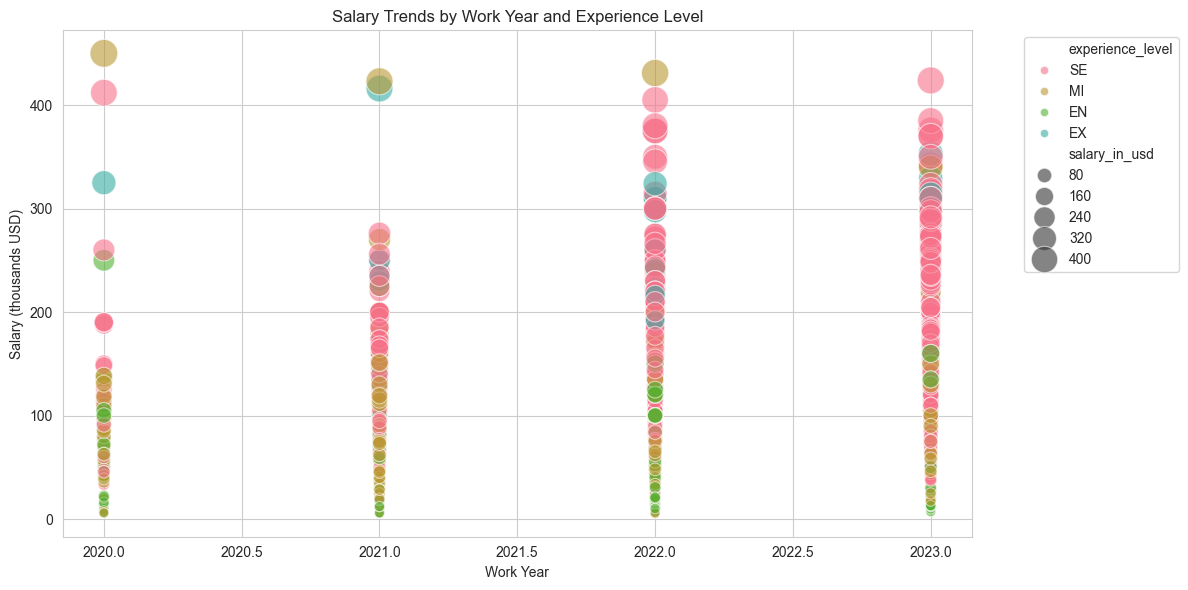

In [26]:
# 2.5 Salary by Work Year and Experience
plt.figure(figsize=(12, 6))
sns.scatterplot(data=processed_data, x='work_year', y='salary_in_usd', hue='experience_level', size='salary_in_usd',
                    sizes=(50, 400), alpha=0.6)
plt.title('Salary Trends by Work Year and Experience Level')
plt.xlabel('Work Year')
plt.ylabel('Salary (thousands USD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Markup: This scatter plot explores the intersection of time, experience, and salary. By using color and size to represent experience levels and salary magnitude, we can visualize how compensation evolves across different years and career stages.

## 3. Model Building and Evaluation

In [11]:
def build_model(data):
    # Prepare features and target
    feature_cols = ['work_year', 'experience_level_encoded', 'employment_type_encoded',
                   'job_title_encoded', 'employee_residence_encoded', 'company_location_encoded',
                   'company_size_encoded']
    
    X = data[feature_cols]
    y = data['salary_in_usd']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train XGBoost model
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    return model, X_test, y_test, y_pred, X_train, feature_cols

In [12]:
# Build and evaluate model
model, X_test, y_test, y_pred, X_train, feature_cols = build_model(processed_data)

## 4. Error Analysis

In [13]:
def analyze_errors(data, model, X_test, y_test, y_pred, X_train, feature_cols):
    # Calculate error metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Performance Metrics:")
    print(f"RMSE: {rmse:.2f}k")
    print(f"MAE: {mae:.2f}k")
    print(f"R2 Score: {r2:.3f}")
    
    # Create error analysis visualizations
    # 1. Predicted vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Salary (thousands USD)')
    plt.ylabel('Predicted Salary (thousands USD)')
    plt.title('Predicted vs Actual Salaries')
    plt.show()
    
    # 2. Error Distribution
    errors = y_pred - y_test
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30)
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Prediction Error (thousands USD)')
    plt.ylabel('Count')
    plt.show()
    
    # 3. Feature Importance
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance, x='importance', y='feature')
    plt.title('Feature Importance')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    # 4. Error Analysis by Experience Level
    test_data = pd.DataFrame({
        'actual': y_test,
        'predicted': y_pred,
        'error': errors,
        'experience_level': data.loc[y_test.index, 'experience_level']
    })
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=test_data, x='experience_level', y='error')
    plt.title('Prediction Errors by Experience Level')
    plt.xlabel('Experience Level')
    plt.ylabel('Prediction Error (thousands USD)')
    plt.xticks(rotation=45)
    plt.show()

Model Performance Metrics:
RMSE: 50.74k
MAE: 37.86k
R2 Score: 0.348


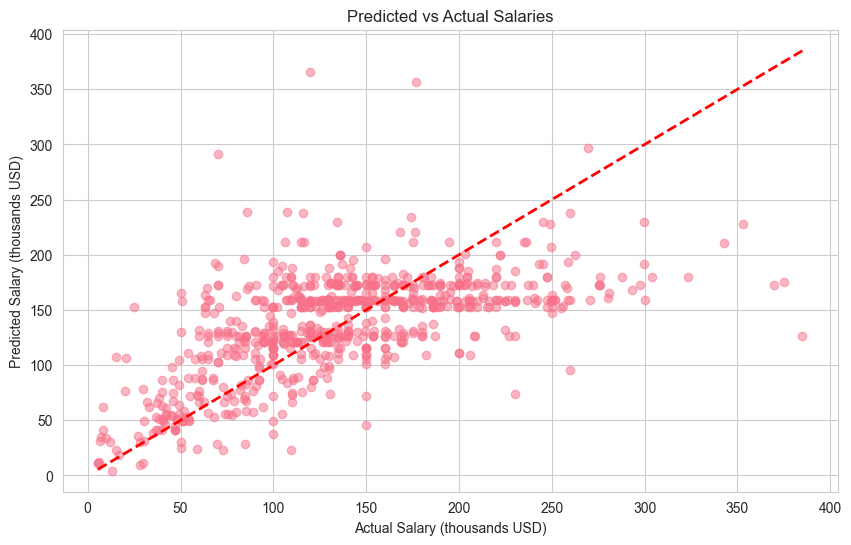

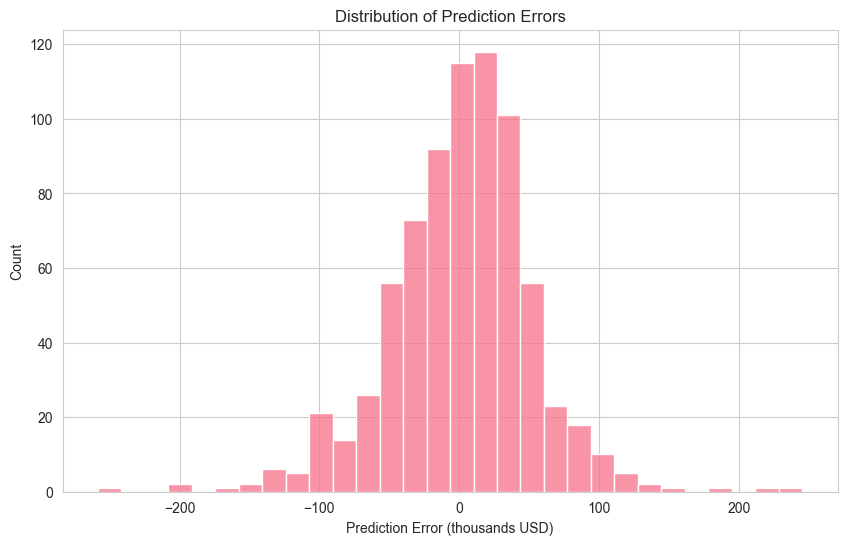

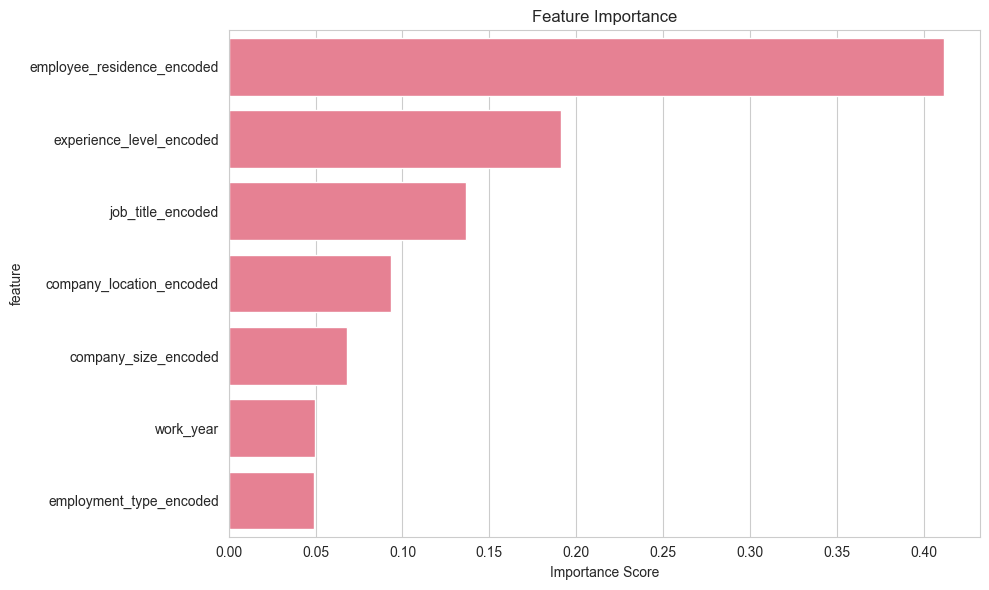

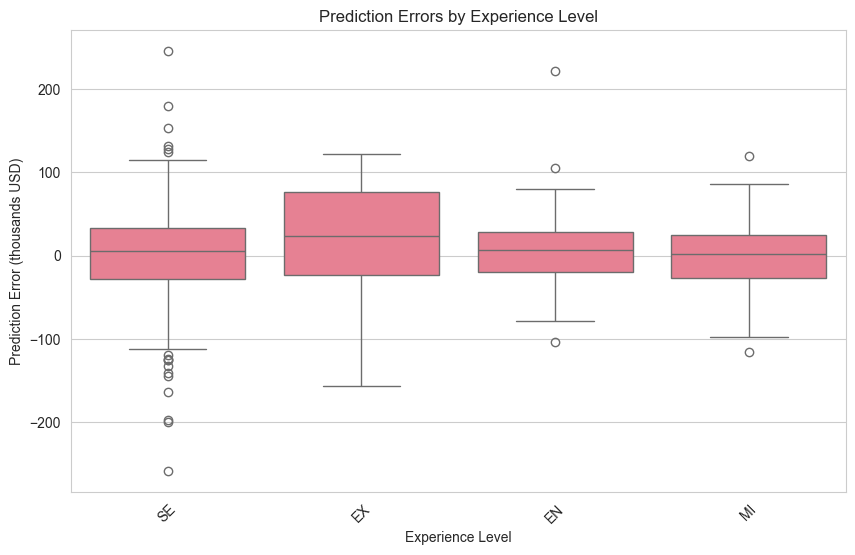

In [14]:
# Analyze errors
analyze_errors(processed_data, model, X_test, y_test, y_pred, X_train, feature_cols)